# Training QBM with Gaussian shot noise

In this notebook, we test how Gaussian shot noise affects on the QBM training. The noise is due to the measurements of QMB and/or target expectation values, whose errors have standard deviations that are respectively referred to as $\kappa$ and $\xi$, in ["On the Sample Complexity of Quantum Boltzmann Machine Learning"](http://arxiv.org/abs/2306.14969).

The XXZ model Hamiltonian in 1D is

$$
\mathcal{H}_{\mathrm{XXZ}}=\sum_{i=1}^{n-1} J\left(\sigma_i^x \sigma_{i+1}^x+\sigma_i^y \sigma_{i+1}^y\right)+\Delta \sigma_i^z \sigma_{i+1}^z+\sum_{i=1}^n h_z \sigma_i^z
$$

and the target state is

$$
\eta=\frac{e^{\mathcal{H}_{\mathrm{XXZ}}}}{Z}
$$

We choose the parameters

* $J=-0.5$
* $\Delta=-0.7$
* $h_z=-0.8$

In [1]:
J = -0.5
Delta = -0.7
hz = -0.8

## Define the parameters of the model: QBM

Here we select the number of qubits of the Gibbs state, the model Hamiltonian to use in the definition of the QBM, and the training hyperparameters. We do not add noise on the Gibbs state to the training, but we add noise on the calculation of the gradients. We refer to it as shot noise and give it a standard deviation of $\sigma$.

In [2]:
import numpy as np

##########
# CONFIG #
##########

rng = np.random.default_rng(seed=1)

n_qubits = 4
model_label = 6  # 6: Geometrically local 1D chain
depolarizing_noise = 0.0  # if noisy expectation values
learning_rate = 0.01
epochs = 1000
eps = 1e-6
compute_qre = True
shot_noise_sigma = 0.01  # Standard deviation for the Gaussian shot noise

The model Hamiltonian is defined as a list of operators $H = \sum_{i=0}^m \theta_i H_i $

In [3]:
from qbm_quimb import hamiltonians

# A list of operators in the model Hamiltonian
model_ham_ops, model_ham_names = hamiltonians.hamiltonian_operators(
    n_qubits, model_label, return_names=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We have `m` terms in the Hamiltonian

In [4]:
m = len(model_ham_names)
print(m)

21


## Define the data

Here we work with _quantum_ data in the form of the Gibbs state of a target Hamiltonian at a fixed inverse temperature $\beta$.
The target Hamiltonian is a subset of the model Hamiltonian.


In [5]:
from qbm_quimb import data

########
# DATA #
########

# We use the label 6 to generate the terms in the target hamiltonian
# but we fix them using J, Delta, and hz
target_label = 6
target_params = np.array(3 * [J] + 4 * [0] + 3 * [J] + 4 * [0] + 3 * [Delta] + 4 * [hz])
target_beta = -1.0  # use -1 to match with the definition of the thermal state

In [6]:
assert m == target_params.shape[0]

In [7]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

The expectation values of the model Hamiltonian operators are computed with respect to the target Gibbs state.

In [8]:
target_expects  # expectation values w.r.t. target density matrix

[-0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 4.3845086613330065e-17,
 6.914681537656912e-17,
 -7.962046540739132e-17,
 5.21593229966328e-18,
 -0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 2.7733391199176196e-32j,
 3.4666738998970245e-33j,
 -3.851859888774472e-33j,
 4.7955655615242173e-32j,
 -0.4086864138659327,
 -0.4919460461791575,
 -0.40868641386593313,
 -0.37920165144017504,
 -0.11550306008696522,
 -0.11550306008696494,
 -0.37920165144017476]

Text(0, 0.5, 'Expectation values')

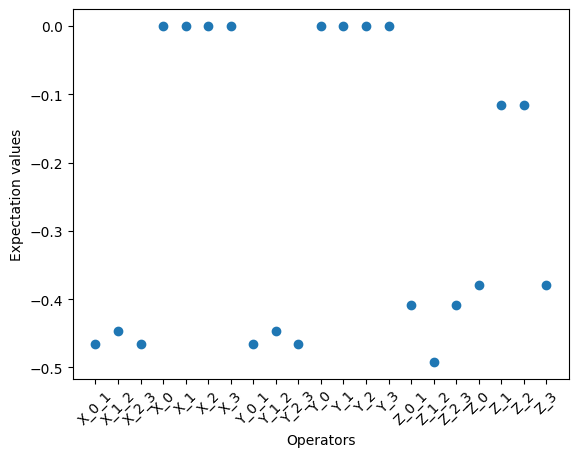

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.asarray(target_expects).real, "o")
plt.xticks(np.arange(len(model_ham_names)), model_ham_names, rotation=45)
plt.xlabel("Operators")
plt.ylabel("Expectation values")

## Start the training by minimizing the relative entropy

We initialize the parameters of the model QBM and then train with stochastic gradient descent (SGD)

In [10]:
from qbm_quimb.training import QBM, train_qbm


#############
# QBM Model #
#############

initial_params = rng.normal(size=len(model_ham_ops))
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [ 0.34558419  0.82161814  0.33043708 -1.30315723  0.90535587  0.44637457
 -0.53695324  0.5811181   0.3645724   0.2941325   0.02842224  0.54671299
 -0.73645409 -0.16290995 -0.48211931  0.59884621  0.03972211 -0.29245675
 -0.78190846 -0.25719224  0.00814218]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


The training is performed with Gaussian shot noise, which is represetend by a random variable sampled from a Normal distribution with zero mean and standard deviation $\sigma$.

In [11]:
import quimb as qu
################
# QBM Taininig #
################

target_eta = target_state
target_eval = qu.eigvalsh(target_eta).clip(1e-300)  # clip near zero for numerical stability

qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    sigma=shot_noise_sigma,
    compute_qre=compute_qre,
    target_eta=target_eta,
    target_eta_ev=target_eval,
)

print(f"Trained parameters: {qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
print(f"Initial relative entropy: {qre_hist[0]}")
print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.82871217e-01 -4.83620286e-01 -4.93691394e-01  4.02017851e-04
  2.20920485e-03  2.55512244e-03  1.51352455e-03 -4.90607361e-01
 -4.75552978e-01 -5.00473981e-01  3.22234213e-04 -1.80259351e-04
 -3.04811546e-03 -2.81427826e-03 -6.33278754e-01 -6.45491618e-01
 -5.47167088e-01 -7.31216950e-01 -6.70943600e-01 -5.95193495e-01
 -6.61610149e-01]
Max. gradients: 0.0401549301765059
Initial relative entropy: 4.566710135251047
Trained relative entropy: 0.00536870313587734


## Plot training history

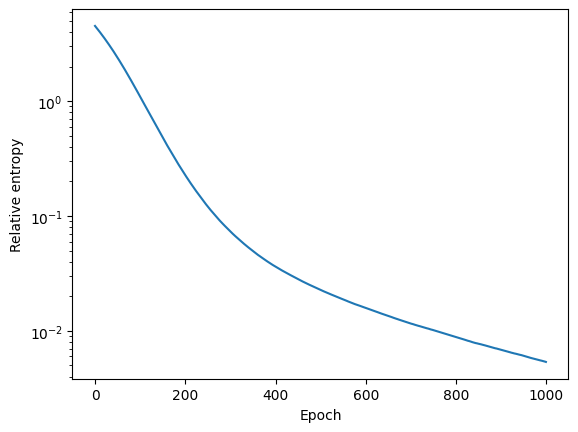

In [12]:
import matplotlib.pyplot as plt 

plt.plot(qre_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Relative entropy")
plt.yscale("log")
plt.show()

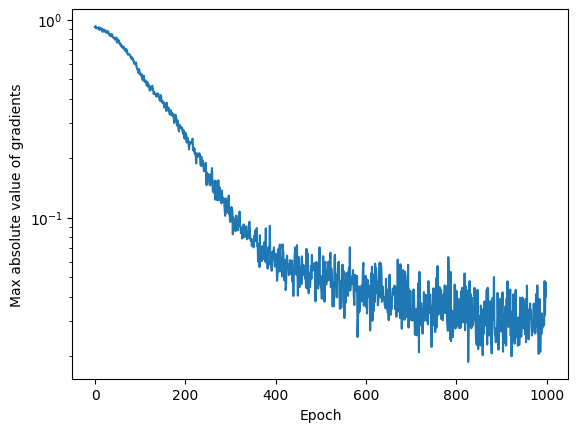

In [13]:
plt.plot(max_grads_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Max absolute value of gradients")
plt.yscale("log")
plt.show()